First, read in the data and check out the columns:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all.count()

koi.1                    8826
rprs                     8440
secthresh                8440
maxrad                   8440
pr_heb                   8145
pr_heb_Px2               8145
pr_eb                    8145
pr_eb_Px2                8145
pr_beb                   8145
pr_beb_Px2               8145
L_tot                    8148
fp                       8148
FPP                      8145
kepid                    8616
period                   8616
rp                       8321
disposition              8616
prob_ontarget            6786
pos_prob_score           7470
not_transitlike          8826
significant_secondary    8826
centroid_offset          8826
ephem_match              8826
MES                      7260
exception                 678
has_ttv                  8556
dtype: int64

Now, we want to split up this whole population into distinct subsets, based on sequential categorizations, in the following order:

* Archive disposition (based on the cumulative table). CONFIRMED and FALSE POSITIVE are their own category; CANDIDATE gets further subdivided.  
* Whether the `vespa` calculation worked or not.
* Whether positional probability calculation is reliable (based on `prob_score_thresh`).  Unreliable goes into "uncertain" category; 
* Reliable positional probs gets further divided based on prob > 0.99 or not.
* Positional prob > 0.99 gets further divided by FPP.  The "newly validated" subset is the subset of these with FPP < 0.01

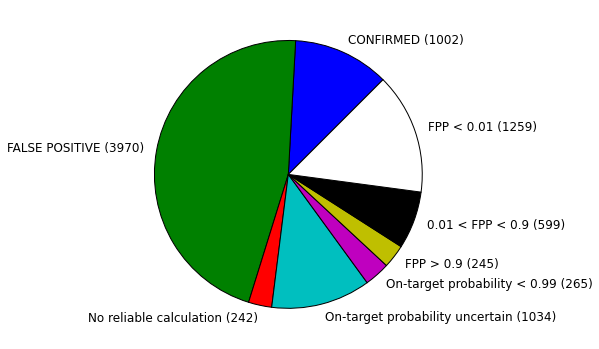

In [2]:
prob_score_thresh = 0.3

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all['FPP'] < 0.01
hi_fpp = fpp_all['FPP'] > 0.9
med_fpp = (fpp_all['FPP'] >= 0.01) & (fpp_all['FPP'] <=0.9)
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['L_tot'] > 1e-3
crazy = fpp_all['L_tot'] <= 1e-3

fpp_calculated = np.isfinite(fpp_all['FPP']) #whether FPP calculation worked

##Just some checks to see if things add up properly
#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp)

categories = [ confirmed, known_fp, 
              (candidate & ~fpp_calculated) | (candidate & fpp_calculated & crazy),
              (candidate & fpp_calculated & not_crazy & target_ambiguous),
              (candidate & fpp_calculated & not_crazy & off_target),
              newfp, newmed, newval]

labels = ['CONFIRMED ({})'.format(categories[0].sum()),
          'FALSE POSITIVE ({})'.format(categories[1].sum()),
          'No reliable calculation ({})'.format(categories[2].sum()),
          'On-target probability uncertain ({})'.format(categories[3].sum()),
          'On-target probability < 0.99 ({})'.format(categories[4].sum()), 
          'FPP > 0.9 ({})'.format(categories[5].sum()), 
          '0.01 < FPP < 0.9 ({})'.format(categories[6].sum()), 
          'FPP < 0.01 ({})'.format(categories[7].sum())]

needmore = categories[2] | categories[3] | categories[4]

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=45);

Let's take a look at just the validated subset, and write that to a file:

In [4]:
fpp_all[newval].count()
fpp_all[newval].to_csv('newly_validated.csv')

In [5]:
fpp_all[newval].head()

,koi.1,rprs,secthresh,maxrad,pr_heb,pr_eb,pr_beb,L_tot,fp,FPP,...,rp,disposition,prob_ontarget,pos_prob_score,not_transitlike,significant_secondary,centroid_offset,ephem_match,exception,has_ttv
koi,,,,,,,,,,,,,,,,,,,,,
K00049.01,K00049.01,0.026,52,0.50,3.030000e-90,0.000000e+00,2.500000e-08,1910.00,0.207,2.500000e-08,...,2.580020,CANDIDATE,1,1,False,False,False,False,NaN,False
K00089.01,K00089.01,0.017,34,0.72,3.130000e-10,1.830000e-05,6.390000e-07,1.22,0.103,1.900000e-05,...,3.822486,CANDIDATE,1,1,False,False,False,False,NaN,True
K00105.01,K00105.01,0.031,27,0.50,1.440000e-03,6.570000e-03,9.190000e-06,1986.00,0.178,8.030000e-03,...,3.093080,CANDIDATE,1,1,False,False,False,False,NaN,False
K00107.01,K00107.01,0.019,21,0.50,4.090000e-24,2.890000e-32,8.650000e-09,36.40,0.160,8.650000e-09,...,3.308772,CANDIDATE,1,1,False,False,False,False,NaN,False
K00110.01,K00110.01,0.021,19,0.50,3.680000e-07,7.420000e-03,3.100000e-15,739.50,0.112,7.420000e-03,...,3.325020,CANDIDATE,1,1,False,False,False,False,NaN,False


4646


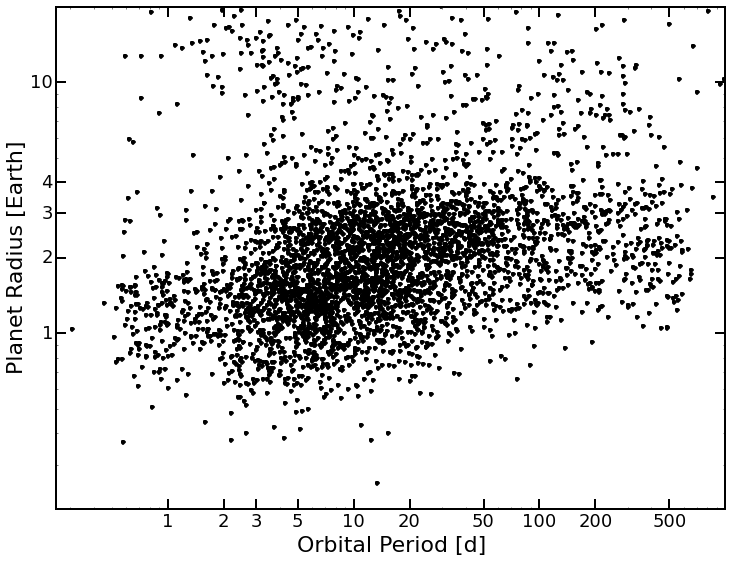

In [42]:
df = fpp_all[confirmed | candidate]

def RPplot(df, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(12,9))
    else:
        fig = plt.gcf()
    ax.plot(df.period, df.rp, '.', **kwargs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.25,1000)
    ax.set_ylim(0.2,20)
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel('Orbital Period [d]', fontsize=22)
    ax.set_ylabel('Planet Radius [Earth]', fontsize=22)
    ax.set_xticks([1,2,3,5,10,20,50,100,200,500])
    ax.set_yticks([1,2,3,4,10])
    ax.tick_params(axis='both', which='major', labelsize=18, length=10, width=2)
    print(len(df))
    return fig, ax
    
RPplot(df, color='k')
plt.savefig('PR_all.png')

4646
1936


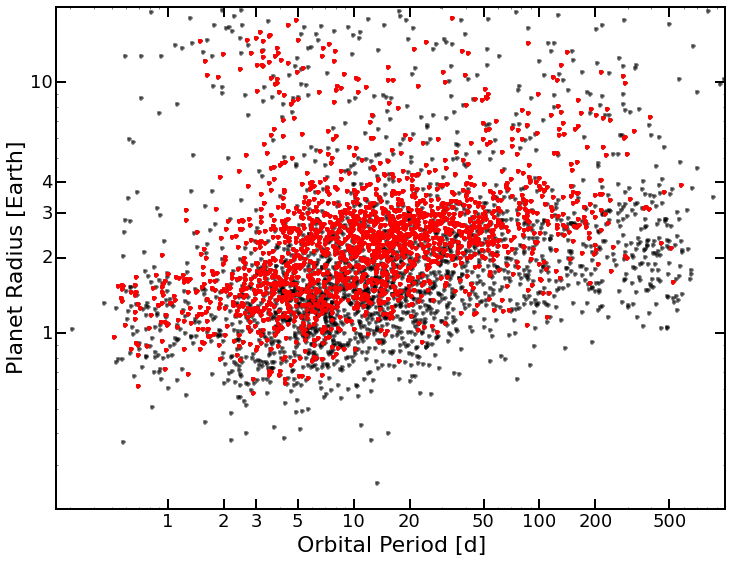

In [43]:
df1 = fpp_all[confirmed | candidate]
df2 = fpp_all[(confirmed | candidate) & low_fpp & on_target & not_crazy]
fig, ax = RPplot(df1, color='k', alpha=0.5)
fig, ax = RPplot(df2, ax=ax, color='r')
plt.savefig('RP_lofpp.png')